In [1]:
# Import Libraries:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import time

## Modelo de movimento diferencial com dois motores e codificadores rotacionais

Para conduzir um robô de rastreio ('tracking robot') com dois motores (um motor à esquerda e outro à direita), controlamos a velocidade de cada roda para definir a trajetória do robô no plano $ (x, y) $. Neste tipo de robôs diferenciais, o movimento é determinado pela diferença de velocidade entre as rodas esquerda e direita.

### Modelação do Movimento do Robô no Plano (x, y) 

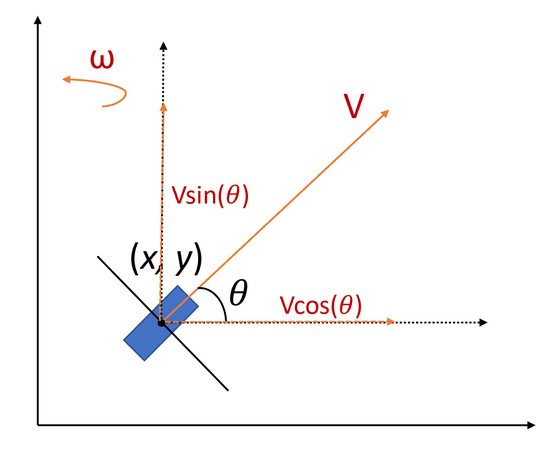

Suponhamos que:
- $ v_L $ é a velocidade linear da roda esquerda,
- $ v_R $ é a velocidade linear da roda direita,
- $ R $ é o raio da roda,
- $ d $ é a distância entre as rodas esquerda e direita (a base do robô).

### Velocidade Linear e Rotacional do Robô

A velocidade linear $v$ do robô (no centro do eixo entre as rodas) e a velocidade angular $ \omega $ (rotações por segundo) em torno do centro do robô são dadas por:

$$
v = \frac{v_L + v_R}{2}
$$

$$
\omega = \frac{v_R - v_L}{d}
$$

### Equações de Movimento

Se o robô começa num ponto inicial $ (x_0, y_0) $ com uma orientação inicial $ \theta_0 $ (ângulo em relação ao eixo $ x $), a posição do robô no tempo $ t $ pode ser calculada integrando a velocidade e a rotação ao longo do tempo. As equações de movimento são:

$$
x(t) = x_0 + \int_0^t v \cos(\theta(\tau)) \, d\tau
$$

$$
y(t) = y_0 + \int_0^t v \sin(\theta(\tau)) \, d\tau
$$

$$
\theta(t) = \theta_0 + \int_0^t \omega \, d\tau
$$

### Implementação Discreta

Para uma implementação discreta (em intervalos de tempo $ \Delta t $), podemos aproximar estas integrais para atualizar o estado do robô em cada instante $ k $:

$$
x_{k+1} = x_k + v \cos(\theta_k) \Delta t
$$

$$
y_{k+1} = y_k + v \sin(\theta_k) \Delta t
$$

$$
\theta_{k+1} = \theta_k + \omega \Delta t
$$

### Planeamento do Movimento

Para conduzir o robô do ponto inicial ao ponto final, respeitando a orientação inicial e a orientação final desejada, podemos dividir o movimento em três etapas:

1. **Rotação Inicial**: Alinhar o robô na direção do ponto final.
2. **Translação**: Mover em linha reta até o ponto final.
3. **Rotação Final**: Ajustar a orientação para a orientação final desejada.

Suponhamos que:
- $ (x_0, y_0) $ e $ \theta_0 $ representam a posição e orientação iniciais do robô.
- $ (x_f, y_f) $ e $ \theta_f $ representam a posição e orientação finais desejadas do robô.
- A distância entre as rodas do robô é $ d $, e o controle é feito ajustando as velocidades angulares das rodas esquerda e direita.

#### Rotação Inicial

Primeiro, precisamos alinhar o robô na direção do ponto final $ (x_f, y_f) $.

1. **Cálculo do Ângulo de Direção**: Calcule o ângulo de orientação desejada, $ \theta_d $, entre o ponto inicial $ (x_0, y_0) $ e o ponto final $ (x_f, y_f) $:

   $$
   \theta_d = \arctan\left(\frac{y_f - y_0}{x_f - x_0}\right)
   $$

2. **Rotação até $ \theta_d $**: Ajuste a velocidade angular $ \omega $ do robô para alinhar a orientação atual $ \theta_0 $ com $ \theta_d $. A rotação pode ser feita definindo as velocidades das rodas esquerda e direita, $ v_L $ e $ v_R $, com sinais opostos:

   - Se $ \theta_0 < \theta_d $, rode o robô no sentido anti-horário.
   - Se $ \theta_0 > \theta_d $, rode o robô no sentido horário.

   A rotação é realizada com:
   
   $$
   v_L = -v \quad \text{e} \quad v_R = v
   $$

   onde $ v $ é a velocidade desejada, de modo a gerar uma velocidade angular constante $ \omega = \frac{2v}{d} $ até que o robô atinja $ \theta_d $.

#### Translação em Linha Reta até o Ponto Final

Uma vez alinhado na direção do ponto final, o robô pode mover-se em linha reta até o ponto $ (x_f, y_f) $.

1. **Distância até o Ponto Final**: Calcule a distância $ d_f $ entre a posição atual $ (x, y) $ e o ponto final $ (x_f, y_f) $:

   $$
   d_f = \sqrt{(x_f - x)^2 + (y_f - y)^2}
   $$

2. **Movimento em Linha Reta**: Mova o robô para frente com uma velocidade linear constante $ v $ até percorrer a distância $ d_f $. Durante este movimento, a velocidade angular deve ser zero para manter o robô na linha reta:

   $$
   v_L = v \quad \text{e} \quad v_R = v
   $$

   Continue o movimento até que a posição atual do robô atinja o ponto $ (x_f, y_f) $.

#### Rotação Final

Finalmente, o robô deve ajustar a sua orientação para o ângulo final desejado $ \theta_f $.

1. **Diferença de Orientação**: Calcule a diferença angular $ \Delta \theta $ entre a orientação atual $ \theta $ e a orientação final $ \theta_f $:

   $$
   \Delta \theta = \theta_f - \theta
   $$

2. **Rotação para $ \theta_f $**: Ajuste novamente as velocidades das rodas com sinais opostos para criar uma rotação até que a orientação atual coincida com $ \theta_f $.

   - Se $ \theta < \theta_f $, rode o robô no sentido anti-horário.
   - Se $ \theta > \theta_f $, rode o robô no sentido horário.

   A rotação final é realizada com:

   $$
   v_L = -v \quad \text{e} \quad v_R = v
   $$

   até que o ângulo do robô seja igual a $ \theta_f $.


# Condução ao longo de segmento linear

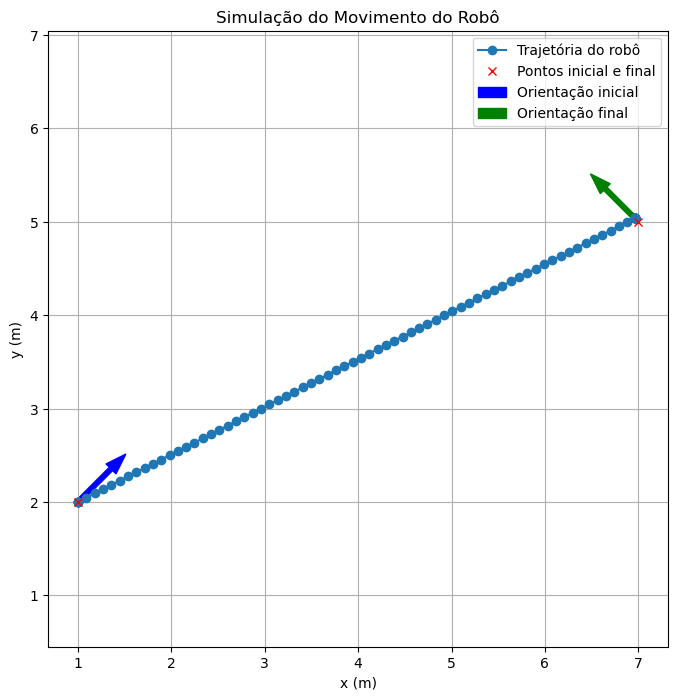

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do robô
v_linear = 1.0        # Velocidade linear (m/s)
v_angular = np.pi/4   # Velocidade angular (rad/s)

dt = 0.1              # Intervalo de tempo (s)

# Coordenadas e orientações iniciais e finais
x0, y0, theta0 = 1, 2, np.pi/4           # Ponto inicial e orientação inicial
xf, yf, thetaf = 7, 5, 3*np.pi/4         # Ponto final e orientação final

# Inicialização das variáveis
x, y, theta = x0, y0, theta0
trajectory_x = [x]
trajectory_y = [y]

# 1. Rotação inicial para alinhar o robô na direção do ponto final
theta_d = np.arctan2(yf - y0, xf - x0)
while abs(theta - theta_d) > 0.01:  # Até atingir a orientação desejada
    if theta < theta_d:
        theta += v_angular * dt
    else:
        theta -= v_angular * dt
    trajectory_x.append(x)
    trajectory_y.append(y)

# 2. Translação em linha reta até o ponto final
distance = np.sqrt((xf - x)**2 + (yf - y)**2)
while distance > 0.1:  # Até atingir o ponto final
    x += v_linear * np.cos(theta) * dt
    y += v_linear * np.sin(theta) * dt
    distance = np.sqrt((xf - x)**2 + (yf - y)**2)
    trajectory_x.append(x)
    trajectory_y.append(y)

# 3. Rotação final para atingir a orientação final desejada
while abs(theta - thetaf) > 0.01:  # Até atingir a orientação final
    if theta < thetaf:
        theta += v_angular * dt
    else:
        theta -= v_angular * dt
    trajectory_x.append(x)
    trajectory_y.append(y)

# Plot da trajetória
plt.figure(figsize=(8, 8))
plt.plot(trajectory_x, trajectory_y, '-o', label="Trajetória do robô")
plt.plot([x0, xf], [y0, yf], 'rx', label="Pontos inicial e final")
plt.arrow(x0, y0, 0.5 * np.cos(theta0), 0.5 * np.sin(theta0), color="blue", width=0.05, label="Orientação inicial")
plt.arrow(xf, yf, 0.5 * np.cos(thetaf), 0.5 * np.sin(thetaf), color="green", width=0.05, label="Orientação final")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.title("Simulação do Movimento do Robô")
plt.axis("equal")
plt.grid(True)
plt.show()


# Velocidade: linear, angular, esquerda, direita

## Medir velocidades com codificadores
Para incorporar as medições de velocidade usando os codificadores da roda esquerda e direita, precisamos entender que a velocidade de cada roda é determinada a partir das contagens dos codificadores em intervalos de tempo específicos. Cada codificador mede o número de "pulsos" ou "contagens" que ocorrem enquanto a roda gira, o que nos permite calcular a distância percorrida por cada roda e, portanto, a velocidade.

Vamos supor:
- $N_L$ e $N_R$ são as contagens de pulsos dos codificadores da roda esquerda e da roda direita, respetivamente, durante o intervalo de tempo $ \Delta t $.
- $P$ é o número de impulsos por rotação completo da roda (resolução do codificador).
- $R$ é o raio de cada roda.

Para o robot Zumo, o valor de $P$, o número de impulsos por rotação completo da roda (resolução do codificador), pode ser obtido da documentação online em: https://www.pololu.com/docs/0J63/3.4 $P = 900 CPR = 75 \cdot 12 CPR $ em que $CPR$ são as contagens por revolução do eixo, $75$ é o fator de redução da engrenagem mecânica entre o eixo da roda e o eixo do motor elétrico, e $12$ CPR as contagens de impulsos por rotação do eixo do motor. 

O raio da roda $R$ pode ser medido ou estimado da informação disponivel, é é o raio de cada roda.

Em alternativa, podem determinar em laboratório qual o incremento dos contadores para cada centímetro de movimento.

Seja qual o método de definir estes parâmetros, eles nunca serão 'perfeitos', ou seja, estarão associados a uma inverteza ou um 'erro' que deve ser mantida tão pequeno quanto possível, no entanto, nunca poderá ser eliminado. Como se vai ver adiante, esta incerteza introduz incerteza no control do movimento e estimação de velocidade e posição.

A distância percorrida por cada roda durante $ \Delta t $ pode ser obtida a partir da contagem de pulsos e da circunferência da roda ($ 2 \pi R $). Se $ N_L $ e $ N_R $ são as contagens de pulsos para a roda esquerda e direita, respetivamente, e $ \Delta N_L $ e $\Delta  N_R $ a variação das contagens desde a última medida, então a distância percorrida por cada roda ($ d_L $ para a roda esquerda e $ d_R $ para a direita) no intervalo de temp $dt$ é:

$$
\Delta d_L = \frac{\Delta N_L}{P} \cdot 2 \pi R
$$

$$
\Delta d_R = \frac{\Delta N_R}{P} \cdot 2 \pi R
$$

As velocidades lineares de cada roda, $ v_L $ e $ v_R $, são então dadas por:

$$
v_L = \frac{\Delta d_L}{\Delta t} = \frac{\Delta N_L}{P} \cdot \frac{2 \pi R}{\Delta t}
$$

$$
v_R = \frac{\Delta d_R}{\Delta t} = \frac{\Delta N_R}{P} \cdot \frac{2 \pi R}{\Delta t}
$$


## Calibrar as velocidades
À semelhança da calibração de velocidade'PWM vs RPM' dos motores e do aeropendulo,  será necessário calibrar o controlo direto da velocidade do robot.

No modelo mais simples de 'condução diferencial' do motor ('differential drive')  o movimento é controlado através do par de velocidades da roda da esquerda $v_L$ e da roda da direita $v_R$. Estes são controlados através de um sinal PWM ('Pulse width modulation') que está integrado através dos métodos de controlo de motor do Zumo. O sentido de rotação e o fator de ciclo são controlados através de um parâmetro adimensional, de $pwm_L$ e $pwm_R$ (número digital, valores inteiros, positivos ou negativos).
- $pwm_L$ e $pwm_R$ representam valores digitais, ou seja são múltiplos da unidade elementar de um 'bit' (binary digit). Em informática é boa prática usar o termo 'LSB', que significa 'Least Bignificant Bit', para explicitar o bit elementar, e associar ao número digital 'LSB' como unidade adimensional. 
-  De acordo com a informação na página do Zumo, e exemplos disponiveis no Arduino, temos:
 $$ -400 \, LSB < pwm_R <400 \, LSB$$
 $$ -400 \, LSB < pwm_L <400 \, LSB$$
- Começa se por assumir um modelo linear de ordem zero para a calibração
 $$ v_R=C_R \cdot pwm_R$$
 $$ v_L=C_L \cdot pwm_L$$
No entanto, é preciso ter cautela, uma vez que, como se viu por exemplo no caso da calibração do motor elétrico, a relação 'pwm vs rpm' não seguia esta relação. Nesse caso, não era a desprezar a dinâmica entre o sinal PWM e os seus tempos característicos, a interagir com os tempos caracteristicos, mecânicos e elétricos, do motor DC. Adicionalmente, o circuito do driver elétrico também poderá ter tido um papel. A lição aprendida foi que é preciso analisar com sentido crítico as medidas, e detrminar qual o modelo mais adequado para a curva de calibração. Esta questão só se coloca quando usar uma escala contínua de valores para $pwm_L$ e $pwm_R$. No caso de usar um valor de comando constante por partes, como por exemplo no controlo tipo 'bit-banging' ou seja, 'On-Off', é menos importante esta questão. No entanto, quando usar um controlo com variação contínua, por exemplo no controlo 'PID', é importante conhecer ben a variação da curva de calibração, incluindo as não idealidades e dinâmicas subjacentes.
 
Os coeficientes de calibração $C_R$ e $C_L$ (em unidade de cm/s/LSB) podem ser determinados através dos codificadores, através das equações anteriores:

$$v_R = \frac{2 \pi R}{P} \cdot \frac{\Delta N_R}{\Delta t}$$

$$v_L = \frac{2 \pi R}{P} \cdot \frac{\Delta N_L}{\Delta t}$$

em que $R \approx 2 \, cm$ é o raio das rodas e $P \approx 909 $ as contagens dos encoders por cada volta da roda.

Qual o erro associado aos valores assim obtidos de $v_R$ e $v_L$ ? Em geral, pela fórmula da propagação de erros:
$$ \frac{\Delta v_R}{v_R} = \sqrt{ \left ( \frac{\Delta R}{R} \right ) ^2 + \left ( \frac{\Delta P}{P} \right )^2 +\left ( \frac{\Delta N_R}{N_R} \right ) ^2+ \left ( \frac{\Delta (\Delta t)}{\Delta t} \right ) ^2 } $$ 

Para condições experimentais típicas, é seguro assumir que o erro dominante estará associado a determinação do raio da roda - inclusivamente pela possivel variabilidade das rodas. Assim, o erro é aproximadamente:
$$ \frac{\Delta v_R}{v_R} \approx \frac{\Delta R}{R} $$

Como exemplo: com um valor medido de $ R = (2.0 \pm 0.1 )\, cm$ o erro relativo passa a ser   $ \frac{\Delta v_R}{v_R} = 0.05 \approx 5\%$. Pode não parecer muito, no entanto, terá para sistemas em movimento um efeito cumulativo para a determinação da posição. Ou seja: a determinação da posição será ao longo do tempo cada vez mais incerta. 


Pelo modelo diferencial de condução temos para o robot em geral a velocidade linear $v$ e angular $\omega$

$$
v = \frac{v_R + v_L}{2}
$$

$$
\omega = \frac{v_R - v_L}{d}
$$

Métodos simples do tipo 'start-stop' são adequados para a calibração numa dimensão só, nos casos de translação pura $\omega=0$ ou rotação pura $v=0$. 

Por exemplo, é possivel calibrar a velocidade através de um sistema tipo 'start-stop': por exemplo uma pista linear com uma certa distância conhecida. E cronometrar o tempo de passagem.

 Na prática, na grande maioria de casos experimentais, a condição de comando $pwm_L + pwm_R = 0 $ não resulta em $v_R + v_L = 0$ nem $pwm_R - pwm_L = 0 $ resulta em não resulta em $v_R - v_L = 0$. 

De um modo geral é necessário calibrar em duas dimensões. As calibrações de $v$ e $\omega$ devem ser realizadas num referencial global ou seja, de laboratório, com algum método que permite analisar este movimento em duas dimensões, por exemplo equipar o robot com um símbolo gráfico tipo QR code, e colocar uma camera a detetar e analisar o movimento do robot. 

In [7]:
'''
# Parâmetros do robô
d=10 #cm, distancia entre rodas

# controlo de velocidade (da calibração)
pwm_max=400 #LSB
vmax=10 #cm/s, with pwm_max applied to left and right motor
wmax=2*vmax/d # rad/s, with pwm_max applied to right motor and -pwm_max to left motor 

pwm=200;#valor usado para pwm 'speed'

vmax = vmax*pwm/pwm_max   # Velocidade linear aplicada (cm/s)
wmax = 2*vmax/d   # Velocidade angular aplicada (rad/s)
'''

"\n# Parâmetros do robô\nd=10 #cm, distancia entre rodas\n\n# controlo de velocidade (da calibração)\npwm_max=400 #LSB\nvmax=10 #cm/s, with pwm_max applied to left and right motor\nwmax=2*vmax/d # rad/s, with pwm_max applied to right motor and -pwm_max to left motor \n\npwm=200;#valor usado para pwm 'speed'\n\nvmax = vmax*pwm/pwm_max   # Velocidade linear aplicada (cm/s)\nwmax = 2*vmax/d   # Velocidade angular aplicada (rad/s)\n"

# Definir e calcular trajetorias

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## Waypoints 1 (poligon)

In [11]:
# coordenadas de vertices ('waypoints') de trajetoria alvo

#poligonio = pentagono
wps = [
    (0, 0),
    (180, 0),
    (180, 60),
    (0, 60),
]

# Fechar a trajetoria 
wps.append(wps[0])

#print(wps)

## Waypoints 2 (ellipse)

In [13]:
def ellipse_waypoints(a, b, num_points):
    """
    Calculate waypoints for a figure-eight trajectory.

    Parameters:
    - a (float): Horizontal radius 
    - b (float): Vertical radius 
    - num_points (int): Number of waypoints to calculate.

    Returns:
    - waypoints (list): List of (x, y) tuples representing the trajectory.
    """
    # Generate time parameter t
    t = np.linspace(0, 2 * np.pi, num_points)

    # Calculate waypoints using the parametric equations
    x = a * np.sin(t)
    y = b * np.cos(t)

    # Combine x and y into waypoints
    waypoints = list(zip(x, y))
    return waypoints
    
'''# Example usage
if __name__ == "__main__":
    # Parameters
    a = 30  # Width of the figure-eight (cm)
    b = 20  # Height of the figure-eight (cm)
    num_points = 100  # Number of waypoints

    # Calculate waypoints
    wps = ellipse_waypoints(a, b, num_points)
    #print (waypoints)
    '''

'# Example usage\nif __name__ == "__main__":\n    # Parameters\n    a = 30  # Width of the figure-eight (cm)\n    b = 20  # Height of the figure-eight (cm)\n    num_points = 100  # Number of waypoints\n\n    # Calculate waypoints\n    wps = ellipse_waypoints(a, b, num_points)\n    #print (waypoints)\n    '

## Waypoints 3 (figure eight)

In [15]:
def figure_eight_waypoints(a, b, num_points):
    """
    Calculate waypoints for a figure-eight trajectory.

    Parameters:
    - a (float): Horizontal scaling factor (width of the figure eight).
    - b (float): Vertical scaling factor (height of the figure eight).
    - num_points (int): Number of waypoints to calculate.

    Returns:
    - waypoints (list): List of (x, y) tuples representing the trajectory.
    """
    # Generate time parameter t
    t = np.linspace(0, 2 * np.pi, num_points)

    # Calculate waypoints using the parametric equations
    x = a * np.sin(t)
    y = b * np.sin(t) * np.cos(t)

    # Combine x and y into waypoints
    waypoints = list(zip(x, y))
    return waypoints
'''
# Example usage
if __name__ == "__main__":
    # Parameters
    a = 30  # Width of the figure-eight (cm)
    b = 20  # Height of the figure-eight (cm)
    num_points = 100  # Number of waypoints

    # Calculate waypoints
    wps = figure_eight_waypoints(a, b, num_points)
    #print (waypoints)
    '''

'\n# Example usage\nif __name__ == "__main__":\n    # Parameters\n    a = 30  # Width of the figure-eight (cm)\n    b = 20  # Height of the figure-eight (cm)\n    num_points = 100  # Number of waypoints\n\n    # Calculate waypoints\n    wps = figure_eight_waypoints(a, b, num_points)\n    #print (waypoints)\n    '

## Waypoints 4 (planet orbits)

In [17]:
def calculate_orbit(a, e, T, num_points, scale_distance, scale_velocity):
    """
    Calculate the scaled trajectory and velocities of a celestial body's orbit.

    Parameters:
    - a (float): Semi-major axis of the orbit (AU).
    - e (float): Orbital eccentricity.
    - T (float): Orbital period (Earth years).
    - num_points (int): Number of points in the orbit.
    - scale_distance (float): Scaling factor for distances.
    - scale_velocity (float): Scaling factor for velocities.

    Returns:
    - positions (list of tuple): List of scaled (x, y) positions.
    - velocities (list of tuple): List of scaled (vx, vy) velocities.
    """
    # Generate true anomaly over one orbit
    theta = np.linspace(0, 2 * np.pi, num_points)

    # Calculate the orbital radius using the ellipse equation
    r = a * (1 - e**2) / (1 + e * np.cos(theta))

    # Convert to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Scale distances
    x_scaled = x * scale_distance
    y_scaled = y * scale_distance

    # Calculate velocities (orbital speed formula)
    mu = 4 * np.pi**2  # Gravitational parameter (AU^3 / year^2)
    orbital_speed = np.sqrt(mu * (2 / r - 1 / a))  # Orbital speed (AU/year)
    vx = -orbital_speed * np.sin(theta)
    vy = orbital_speed * np.cos(theta)

    # Scale velocities
    vx_scaled = vx * scale_velocity
    vy_scaled = vy * scale_velocity

    # Combine results
    positions = list(zip(x_scaled, y_scaled))
    velocities = list(zip(vx_scaled, vy_scaled))

    return positions, velocities

'''# Example usage
if __name__ == "__main__":
    # Define orbital parameters for planets and famous comets
    celestial_bodies = {
        "Mercury": {"a": 0.39, "e": 0.205, "T": 0.24},
        "Venus": {"a": 0.72, "e": 0.007, "T": 0.62},
        "Earth": {"a": 1.0, "e": 0.0167, "T": 1.0},
        "Mars": {"a": 1.524, "e": 0.0934, "T": 1.88},
        "Jupiter": {"a": 5.203, "e": 0.0489, "T": 11.86},
        "Saturn": {"a": 9.537, "e": 0.0565, "T": 29.46},
        "Uranus": {"a": 19.191, "e": 0.046, "T": 84.01},
        "Halley's Comet": {"a": 17.8, "e": 0.967, "T": 75.3},
        "Encke's Comet": {"a": 2.21, "e": 0.847, "T": 3.3},
    }

    # Simulation parameters
    num_points = 500  # Number of points per orbit
    scale_distance = 100  # Scale factor for distances (cm per AU)
    scale_velocity = 10  # Scale factor for velocities (cm/s per AU/year)

    # Plot orbits
    plt.figure(figsize=(12, 10))
    for body, params in celestial_bodies.items():
        # Calculate orbit
        positions, velocities = calculate_orbit(
            a=params["a"],
            e=params["e"],
            T=params["T"],
            num_points=num_points,
            scale_distance=scale_distance,
            scale_velocity=scale_velocity,
        )

        # Extract x and y coordinates
        x, y = zip(*positions)

        # Plot orbit
        plt.plot(x, y, label=f"{body} Orbit")
        plt.scatter(x[0], y[0], label=f"{body} Start", s=10, zorder=5)

    # Plot settings
    plt.title("Scaled Orbits of Planets and Comets")
    plt.xlabel("X Position (cm)")
    plt.ylabel("Y Position (cm)")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()
    '''

'# Example usage\nif __name__ == "__main__":\n    # Define orbital parameters for planets and famous comets\n    celestial_bodies = {\n        "Mercury": {"a": 0.39, "e": 0.205, "T": 0.24},\n        "Venus": {"a": 0.72, "e": 0.007, "T": 0.62},\n        "Earth": {"a": 1.0, "e": 0.0167, "T": 1.0},\n        "Mars": {"a": 1.524, "e": 0.0934, "T": 1.88},\n        "Jupiter": {"a": 5.203, "e": 0.0489, "T": 11.86},\n        "Saturn": {"a": 9.537, "e": 0.0565, "T": 29.46},\n        "Uranus": {"a": 19.191, "e": 0.046, "T": 84.01},\n        "Halley\'s Comet": {"a": 17.8, "e": 0.967, "T": 75.3},\n        "Encke\'s Comet": {"a": 2.21, "e": 0.847, "T": 3.3},\n    }\n\n    # Simulation parameters\n    num_points = 500  # Number of points per orbit\n    scale_distance = 100  # Scale factor for distances (cm per AU)\n    scale_velocity = 10  # Scale factor for velocities (cm/s per AU/year)\n\n    # Plot orbits\n    plt.figure(figsize=(12, 10))\n    for body, params in celestial_bodies.items():\n       

## Waypoints 5 (satellite orbits)

In [19]:
def calculate_orbit(a, e, T, num_points, scale_distance, scale_velocity):
    """
    Calculate the scaled trajectory and velocities of a satellite's orbit.

    Parameters:
    - a (float): Semi-major axis of the orbit (km).
    - e (float): Orbital eccentricity.
    - T (float): Orbital period (hours).
    - num_points (int): Number of points in the orbit.
    - scale_distance (float): Scaling factor for distances.
    - scale_velocity (float): Scaling factor for velocities.

    Returns:
    - positions (list of tuple): List of scaled (x, y) positions.
    - velocities (list of tuple): List of scaled (vx, vy) velocities.
    """
    # Generate true anomaly over one orbit
    theta = np.linspace(0, 2 * np.pi, num_points)

    # Calculate the orbital radius using the ellipse equation
    r = a * (1 - e**2) / (1 + e * np.cos(theta))

    # Convert to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Scale distances
    x_scaled = x * scale_distance
    y_scaled = y * scale_distance

    # Calculate orbital speed (simplified; only for circular-like orbits)
    mu = 398600.4418  # Gravitational parameter (km^3/s^2)
    orbital_speed = np.sqrt(mu * (2 / r - 1 / a))  # Orbital speed (km/s)
    vx = -orbital_speed * np.sin(theta)
    vy = orbital_speed * np.cos(theta)

    # Scale velocities
    vx_scaled = vx * scale_velocity
    vy_scaled = vy * scale_velocity

    # Combine results
    positions = list(zip(x_scaled, y_scaled))
    velocities = list(zip(vx_scaled, vy_scaled))

    return positions, velocities

'''# Example usage
if __name__ == "__main__":
    # Define orbital parameters for satellites and historical trajectories
    satellites = {
        # Earth
        "Earth": {"a": 6378, "e": 0.000, "T": 24},
        # LEO examples
        "Hubble Space Telescope": {"a": 6820, "e": 0.0006, "T": 1.54},
        "ISS": {"a": 6771, "e": 0.001, "T": 1.5},
        # MEO examples
        "GPS Satellite": {"a": 26600, "e": 0.01, "T": 11.98},
        "Galileo Satellite": {"a": 29600, "e": 0.005, "T": 14.08},
        # GEO examples
        "Geostationary Satellite": {"a": 42164, "e": 0.0, "T": 24},
    }

    # Simulation parameters
    num_points = 500  # Number of points per orbit
    scale_distance = 0.01  # Scale factor for distances (km to cm)
    scale_velocity = 1.0  # Scale factor for velocities (km/s to cm/s)

    # Plot orbits
    plt.figure(figsize=(12, 10))
    for satellite, params in satellites.items():
        # Calculate orbit
        positions, velocities = calculate_orbit(
            a=params["a"],
            e=params["e"],
            T=params["T"],
            num_points=num_points,
            scale_distance=scale_distance,
            scale_velocity=scale_velocity,
        )

        # Extract x and y coordinates
        x, y = zip(*positions)

        # Plot orbit
        plt.plot(x, y, label=f"{satellite} Orbit")
        plt.scatter(x[0], y[0], label=f"{satellite} Start", s=10, zorder=5)

    # Plot settings
    plt.title("Scaled Orbits of Satellites")
    plt.xlabel("X Position (cm)")
    plt.ylabel("Y Position (cm)")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()
'''

'# Example usage\nif __name__ == "__main__":\n    # Define orbital parameters for satellites and historical trajectories\n    satellites = {\n        # Earth\n        "Earth": {"a": 6378, "e": 0.000, "T": 24},\n        # LEO examples\n        "Hubble Space Telescope": {"a": 6820, "e": 0.0006, "T": 1.54},\n        "ISS": {"a": 6771, "e": 0.001, "T": 1.5},\n        # MEO examples\n        "GPS Satellite": {"a": 26600, "e": 0.01, "T": 11.98},\n        "Galileo Satellite": {"a": 29600, "e": 0.005, "T": 14.08},\n        # GEO examples\n        "Geostationary Satellite": {"a": 42164, "e": 0.0, "T": 24},\n    }\n\n    # Simulation parameters\n    num_points = 500  # Number of points per orbit\n    scale_distance = 0.01  # Scale factor for distances (km to cm)\n    scale_velocity = 1.0  # Scale factor for velocities (km/s to cm/s)\n\n    # Plot orbits\n    plt.figure(figsize=(12, 10))\n    for satellite, params in satellites.items():\n        # Calculate orbit\n        positions, velocities = 

## Plot waypoints trajectory

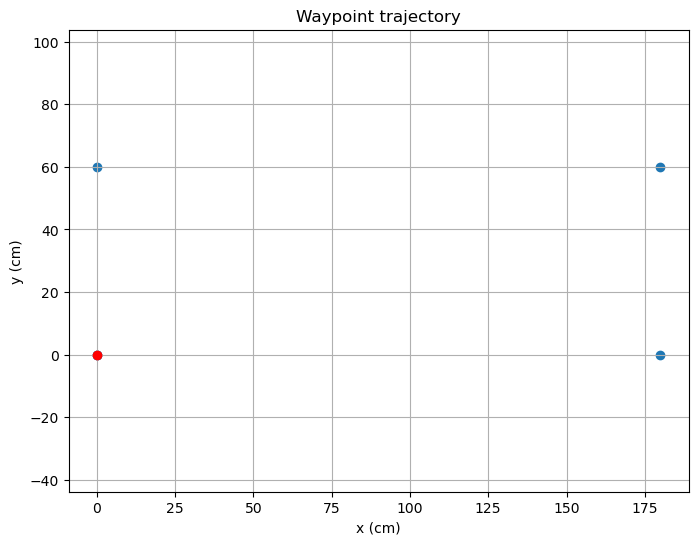

In [21]:
# Plot the trajectory
plt.figure(figsize=(8, 6))

#for i in range(len(wps)):
#    plt.scatter(wps[i][0], wps[i][1])
# Extract x and y coordinates for plotting
x, y = zip(*wps)
plt.scatter(x, y)
plt.scatter(x[0], y[0], color="red", label="Start Point", zorder=5)

plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Waypoint trajectory")
plt.axis("equal")
#plt.legend()
plt.grid(True)
plt.show()

# Condução ao longo de trajetória

## Parâmetros do robô incl. pwm e velocidade linear e angular

In [23]:
# Parâmetros do robô
d=8.5 #cm, distancia entre rodas

# controlo de velocidade
pwm_max=200 
vmax=26.3 #cm/s, with pwm_max applied to left and right motor
wmax=4.79 #rad/s, with pwm_max applied to right and pwm_min to left motor
#wmax=vmax/(d/2) # valor teórico, dava 6.2 rad/s, rad/s 

## Atualizar a posição e orientação do robô em cada segmento

In [25]:
# Função para atualizar a posição e orientação do robô para cada segmento da trajetória
def move_robot(t_start, x_start, y_start, theta_start, x_end, y_end, theta_end):
       
    trajectory=[]
    
    #global t,v,w,x,y,theta
    
    t=t_start 
    v=0
    w=0
    x=x_start
    y=y_start
    theta=theta_start

    # 1. Rotação inicial para alinhar com o ponto final
    w=wmax
    theta_d = np.arctan2(y_end - y_start, x_end - x_start)
    dtheta_before=abs(theta - theta_d)+1 #arbitrar valor anterior ao inicial

    #print('first')
    while abs(theta - theta_d) > 0.01 and abs(theta - theta_d) < dtheta_before:  # Até atingir a orientação desejada
        dtheta_before=abs(theta - theta_d)
        t+=dt
        if theta < theta_d:
            w=wmax
        else:
            w=-1*wmax
        theta += w * dt
        trajectory.append((t,v,w,x,y,theta))

    # 2. Translação em linha reta até o ponto final
    v=vmax
    w=0
    distance = np.sqrt((x_end - x)**2 + (y_end - y)**2)
    distance_before=distance+1  #arbitrar valor anterior
    #print('second')
    while distance > 0.1 and distance<distance_before:  # Até atingir o ponto final
        #print(distance)
        distance_before=distance
        t=t+dt
        x += v * np.cos(theta_d) * dt
        y += v * np.sin(theta_d) * dt
        trajectory.append((t,v,w,x,y,theta))
        distance = np.sqrt((x_end - x)**2 + (y_end - y)**2)

    '''
    # 3. Rotação final para atingir a orientação final desejada
    # (passo desnecessário neste problema)
    v=0
    w=wmax
    dtheta_before=abs(theta - theta_end)+1   #arbitrar valor anterior
    #print('third')
    while abs(theta - theta_end) > 0.01 and abs(theta - theta_end) < dtheta_before:  # Até atingir a orientação final
        #print(abs(theta - theta_end))
        t=t+dt
        if theta < theta_end:
            w=wmax
        else:
            w=-wmax
        theta += w * dt
        trajectory.append((t,v,w,x,y,theta))
        dtheta_before=abs(theta - theta_end)
        '''

    return trajectory

## Calcular parametros da trajetoria total

In [27]:
#start configuration

t0=0  #start time
dt = 0.2             # Intervalo de tempo (s)

# Inicialização da posição e orientação do robô
x0 = wps[0][0] 
y0 = wps[0][1]
theta0 = 0 

# Geração da trajetória completa para todos os segmentos 
full_trajectory= []
full_trajectory.append((t0,0,0,x0,y0,theta0))

#create movement along trajectory 
for i in range(len(wps)-1):
    t_start=full_trajectory[-1][0]
    x_start=wps[i][0]
    y_start=wps[i][1]
    x_end=wps[i+1][0]
    y_end=wps[i+1][1]
    if i==0: 
        theta_start = theta0 
    else:
        theta_start = theta_end_anterior
    theta_end = np.arctan2(y_end - y_start, x_end - x_start)
    segment_trajectory = move_robot(t_start, x_start, y_start, theta_start, x_end, y_end, theta_end)
    full_trajectory.extend(segment_trajectory)
    theta_end_anterior=theta_end

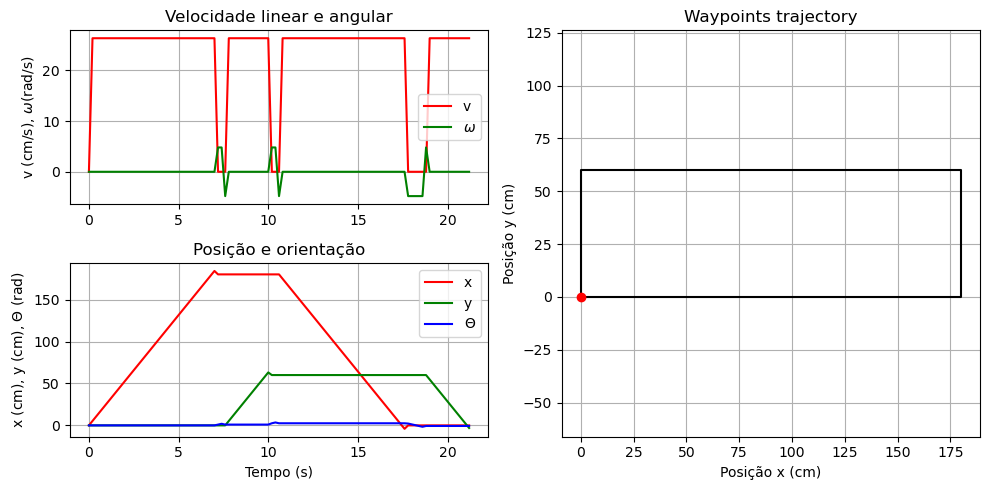

In [43]:
# Configuração da figura e dos subplots
fig = plt.figure(figsize=(10, 5))

t =  [x[0] for x in full_trajectory]  # Eixo do tempo 
v =  [x[1] for x in full_trajectory]  #velocidade linear
w =  [x[2] for x in full_trajectory]  #velocidade angular
x =  [x[3] for x in full_trajectory]  #posicao x
y=  [x[4] for x in full_trajectory]  #posicao y
theta =  [x[5] for x in full_trajectory]  #orientacao teta

# Subplot 1: 
ax1 = fig.add_subplot(2, 2, 1)  # 2 linhas, 2 colunas, posição 1
ax1.plot(t, v, color='red')
ax1.plot(t, w, color='green')
ax1.set_title("Velocidade linear e angular")
ax1.set_ylabel(r'v (cm/s), $\omega$(rad/s)')
ax1.legend(['v',r'$\omega$'])
ax1.grid(True)

# Subplot 2: 
ax2 = fig.add_subplot(2, 2, 3, sharex=ax1)  # 2 linhas, 2 colunas, posição 3
ax2.plot(t, x, color='red')
ax2.plot(t, y, color='green')
ax2.plot(t, (theta), color='blue')
ax2.set_title("Posição e orientação")
ax2.set_xlabel("Tempo (s)")
ax2.set_ylabel(r'x (cm), y (cm), $\Theta$ (rad)')
ax2.legend(['x','y',r'$\Theta$'])
ax2.grid(True)

# Subplot 3: 
ax3 = fig.add_subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
#for i in range(len(wps)):
#    plt.scatter(wps[i][0], wps[i][1])
x, y = zip(*wps)
#plt.scatter(x, y)
plt.scatter(x[0], y[0], color="red", label="Start Point", zorder=5)
ax3.plot(x, y, color='black')
ax3.set_title("Waypoints trajectory")
ax3.set_xlabel("Posição x (cm)")
ax3.set_ylabel("Posição y (cm)")
#ax3.legend(['WP1','WP2','WP3','WP4','WP5','WP6=WP1','Trajectory'])
plt.axis("equal")
ax3.grid(True)

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show();

## Planeamento PWM - gerar séries temporais de PWM para Zumo

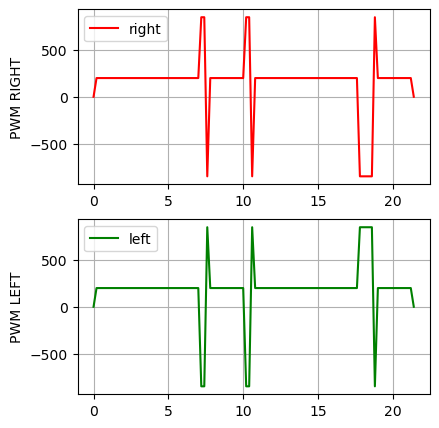

In [30]:
pwm_right=[]
pwm_left=[]

for i in range(len(t)):
    pwm_right.append(pwm_max*(v[i]/vmax+w[i]/wmax*d/2))
    pwm_left.append(pwm_max*(v[i]/vmax-w[i]/wmax*d/2))
pwm_right.append(0)
pwm_left.append(0)
t.append(t[-1]+dt);

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t, pwm_right, color='red')
#ax1.set_title("PWM")
ax1.set_ylabel('PWM RIGHT')
ax1.legend(['right'])
ax1.grid(True)

# Subplot 2: 
ax2 = fig.add_subplot(2, 2, 3, sharex=ax1)
ax2.plot(t, pwm_left, color='green')
ax2.set_ylabel('PWM LEFT')
ax2.legend(['left'])
ax2.grid(True)

## Store simulated pwm values to be used as arduino array

In [32]:
filename="pwmRL.h"

with open(filename, "w") as file:
    file.write('const int n ='+str(int(len(t)))+'; // number points\n')
    file.write('const int dt ='+str(int(1000*dt))+'; // ms update time\n')
    file.write('int pwm_right[]={')
    for row in pwm_right:
        file.write(str(int(row))+',')
    file.write('};\n')
    file.write('int pwm_left[]={')
    for row in pwm_left:
        file.write(str(int(row))+',')
    file.write('};\n')

Read and show file content (has to be created before):

In [34]:
'''
file = open(filename, "r")
content = file.read()
print(content)
file.close()
'''

'\nfile = open(filename, "r")\ncontent = file.read()\nprint(content)\nfile.close()\n'

Copiar o texto para o código arduino, ou melhor ainda, colocar o ficheiro `pwmRL.h` para a correta pasta do código arduino.

Arduino reference code:

```c++
#include "pwmRL.h"

#include <Wire.h>
#include <Zumo32U4.h>

Zumo32U4Motors motors;
Zumo32U4ButtonA buttonA;

unsigned long t0=millis();  
int i=0;

void setup() {
  buttonA.waitForButton();
  delay(1000);
}

void loop() {
  if(i<n && millis()-t0>dt){
  motors.setLeftSpeed(pwm_left[i]);
  motors.setRightSpeed(pwm_right[i]);
  t0=millis();
  i++;
  }
}

```

# Animation

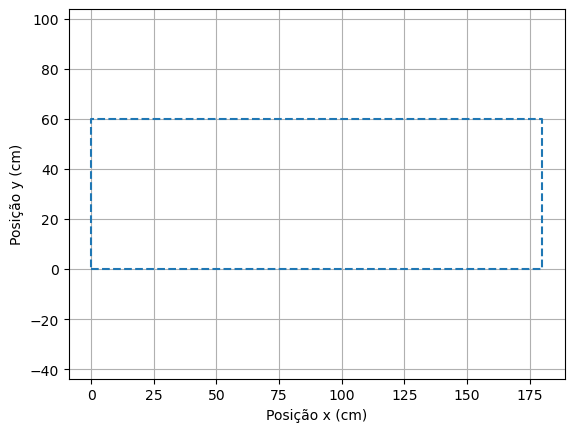

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches## Animação

# Set up our figure for drawing our pendulum
fig, ax = plt.subplots()
#for i in range(len(wps)):
#    plt.scatter(wps[i][0], wps[i][1])
x, y = zip(*wps)
plt.plot(x, y,'--')
#plt.scatter(x[0], y[0], color="red", label="Start Point", zorder=5)
p, = ax.plot([],[], color='cornflowerblue'); # initializes an empty plot
ax.set_xlim([-10, 10])  # X lim
ax.set_ylim([-10, 10])  # Y lim
#ax.set_title("zumo drive")
ax.set_xlabel("Posição x (cm)")
ax.set_ylabel("Posição y (cm)")
#ax.legend(['WP1','WP2','WP3','WP4','WP5','WP6=WP1','Trajectory'])
plt.axis("equal")
ax.grid(True)

#ax.plot(x, y, '--',color='black')
arrow = mpatches.Arrow(0, 0, 1, 0)
ax.add_patch(arrow)


In [39]:
video_title = "zumodrive"
#FPS = 20  #from simulation dt
sample_rate = int(1/dt)
dpi = 300 # quality of the video
writerObj = FFMpegWriter(fps=sample_rate)

with writerObj.saving(fig, video_title+".mp4", dpi):
  for i in range(0, len(t), int(0.8*sample_rate)):
        arrow = mpatches.Arrow(x[i], y[i], np.cos(theta[i]), np.sin(theta[i]))
        ax.add_patch(arrow)
        fig.canvas.draw()
        writerObj.grab_frame()

IndexError: tuple index out of range

In [ ]:
from IPython.display import Video
Video("zumodrive.mp4", embed=True, width=640, height=480)

# Controlo PID

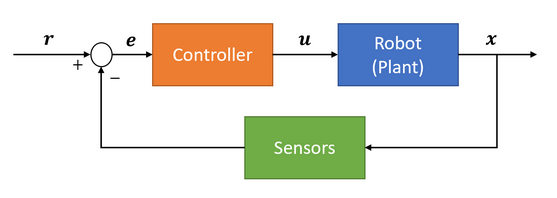

In [ ]:
#### Simulation parameters
dt = 0.01  # Time step (s)
total_time = 4  # Total simulation time (s)
time_steps = int(total_time / dt)

# Robot parameters
pwm_max = 200  # Maximum PWM value
pwm_min = -200  # Minimum PWM value
wheel_radius = 2.0  # Wheel radius (cm)
wheel_distance = 8.5  # Distance between wheels (cm)

# PID controller parameters
Kp = 40
Ki = 0
Kd = 0

# Define the setpoint planner
def setpoint_planner(t):
    if t < 2:
        return t/2  # cm/s
    else:
        return 1-(t-2)/2  # cm/s

# Define the PID controller
def pid_controller(error, integral, derivative):
    """PID controller implementation."""
    return Kp * error + Ki * integral + Kd * derivative

# Define the plant (zumo motors and robot)
def plant(pwm_left, pwm_right, wheel_radius, wheel_distance, dt, state):
    """
    Simulates the dynamics of a differential-drive robot.

    Parameters:
    - pwm_left (int): pwm value left motor
    - pwm_right (int): pwm value right motor
    - wheel_radius (float): Radius of the wheels (cm)
    - wheel_distance (float): Distance between the two wheels (cm)
    - dt (float): Time step (s)
    - state (dict): Current state of the robot containing:
        - x (float): X-coordinate (cm)
        - y (float): Y-coordinate (cm)
        - theta (float): Orientation (rad)
        - v (float): Linear velocity (cm/s)
        - w (float): Angular velocity (rad/s)

    Returns:
    - state (dict): Updated state of the robot.
    """
    # Compute (from calibration) left and right wheel velocities
    v_left = 10*pwm_left/pwm_max# Velocity of the left wheel (cm/s)
    v_right = 10*pwm_right/pwm_max#Velocity of the right wheel (cm/s)
    
    # Compute linear and angular velocities
    v = (v_left + v_right) / 2  # Linear velocity (cm/s)
    w = (v_right - v_left) / (wheel_distance/2)  # Angular velocity (rad/s)

    # Update state (x, y, theta)
    state['x'] += v * np.cos(state['theta']) * dt
    state['y'] += v * np.sin(state['theta']) * dt
    state['theta'] += w * dt

    # Normalize theta to the range [-pi, pi]
    state['theta'] = (state['theta'] + np.pi) % (2 * np.pi) - np.pi

    # Update linear and angular velocities
    state['v'] = v
    state['w'] = w

    return state

# Define the measurement
def measurement(current_velocity):
    """Simulate encoder measurement with noise."""
    noise = np.random.normal(0, 0.01)  # Simulate encoder noise
    return current_velocity + noise

# Initialize variables
time_log = []
measurement_log = []
setpoint_log = []
control_log=[]
error_log = []

# Initial state
state = {
    'x': 0.0,        # X position (cm)
    'y': 0.0,        # Y position (cm)
    'theta': 0.0,    # Orientation (rad)
    'v': 0.0,        # Linear velocity (cm/s)
    'w': 0.0     # Angular velocity (rad/s)
}

# Initial PID controller
integral = 0.0
previous_error = 0.0

# Simulation loop
for step in range(time_steps):
    t = step * dt
    
    # Setpoint planner
    setpoint = setpoint_planner(t)

    # Measurement
    measured_value = measurement(state['v'])  

    # Error calculation
    error = setpoint - measured_value
    integral += error * dt
    derivative = (error - previous_error) / dt

    # PID controller
    control_signal = pid_controller(error, integral, derivative)
    # Control limits
    if(control_signal>pwm_max):control_signal=pwm_max
    if(control_signal<pwm_min):control_signal=pwm_min

    # Plant
    pwm_left=control_signal
    pwm_right=control_signal
    state = plant(pwm_left, pwm_right, wheel_radius, wheel_distance, dt, state)


    # Log data
    time_log.append(t)
    measurement_log.append(measured_value)
    setpoint_log.append(setpoint)
    control_log.append(control_signal)
    error_log.append(error)

    # Update previous error
    previous_error = error

    # Simulate real-time execution
    time.sleep(dt)

# Plot results
plt.figure(figsize=(10, 6))

# Velocity plot
plt.subplot(3, 1, 1)
plt.plot(time_log, measurement_log, label="Measured")
plt.plot(time_log, setpoint_log, label="Setpoint", linestyle="--")
#plt.title("Robot Linear Velocity Control")
plt.ylabel("Velocity (cm/s)")
plt.legend()
plt.grid(True)

# Error plot
plt.subplot(3, 1, 2)
plt.plot(time_log, error_log, label="Error (cm/s)", color="red")
#plt.title("Error")
plt.xlabel("Time (s)")
plt.ylabel("Error (cm/s)")
plt.grid(True)

# Control plot
plt.subplot(3, 1, 3)
plt.plot(time_log, control_log, label="Control", color="green")
#plt.title("Control")
plt.xlabel("Time (s)")
plt.ylabel("Control (PWM)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
    '''
# Example usage of plant model (see below)
if __name__ == "__main__":
    # Parameters
    wheel_radius = 5.0  # Wheel radius (cm)
    wheel_distance = 20.0  # Distance between wheels (cm)
    dt = 0.1  # Time step (s)
    total_time = 20  # Total simulation time (s)
    time_steps = int(total_time / dt)

    # Initial state
    state = {
        'x': 0.0,        # X position (cm)
        'y': 0.0,        # Y position (cm)
        'theta': 0.0,    # Orientation (rad)
        'v': 0.0,        # Linear velocity (cm/s)
        'omega': 0.0     # Angular velocity (rad/s)
    }


    # Generate figure-eight trajectory by varying wheel velocities
    trajectory_x = []
    trajectory_y = []
    
    for step in range(time_steps):
        t = step * dt
    
        # Define wheel velocities
        v_left = 50.0 * np.sin(2 * np.pi  * t / 5)  # Left wheel velocity (cm/s)
        v_right = 50.0 * np.sin(2 * np.pi * t / 5)  # Right wheel velocity (cm/s)
    
        # Update state using differential-drive dynamics
        state = differential_drive_dynamics(v_left, v_right, wheel_radius, wheel_distance, dt, state)
    
        # Store trajectory
        trajectory_x.append(state['x'])
        trajectory_y.append(state['y'])
    
    # Plot trajectory
    plt.figure(figsize=(8, 8))
    plt.plot(trajectory_x, trajectory_y, label="Robot Trajectory")
    plt.scatter(trajectory_x[0], trajectory_y[0], color="red", label="Start", zorder=5)
    plt.title("Figure-Eight Trajectory of Differential-Drive Robot")
    plt.xlabel("X Position (cm)")
    plt.ylabel("Y Position (cm)")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()
    '''

# Trajectory with errors in sensing and acting

# Improving sensing with Kalman filtering and sensor fusion